<a href="https://colab.research.google.com/github/CassioLima09/NLP_with_Transformers/blob/main/05_text-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

#install_requirements() para instalar automaticamente todas as bibliotecas necessárias para os notebooks funcionarem.
#🔹 Isso equivale a rodar pip install -r requirements.txt, mas já está automatizado.

Cloning into 'notebooks'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 530 (delta 183), reused 159 (delta 159), pack-reused 320 (from 2)
Receiving objects: 100% (530/530), 30.79 MiB | 23.76 MiB/s, done.
Resolving deltas: 100% (252/252), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
# hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v1.16.1


# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter05_meena.png?raw=1" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/>

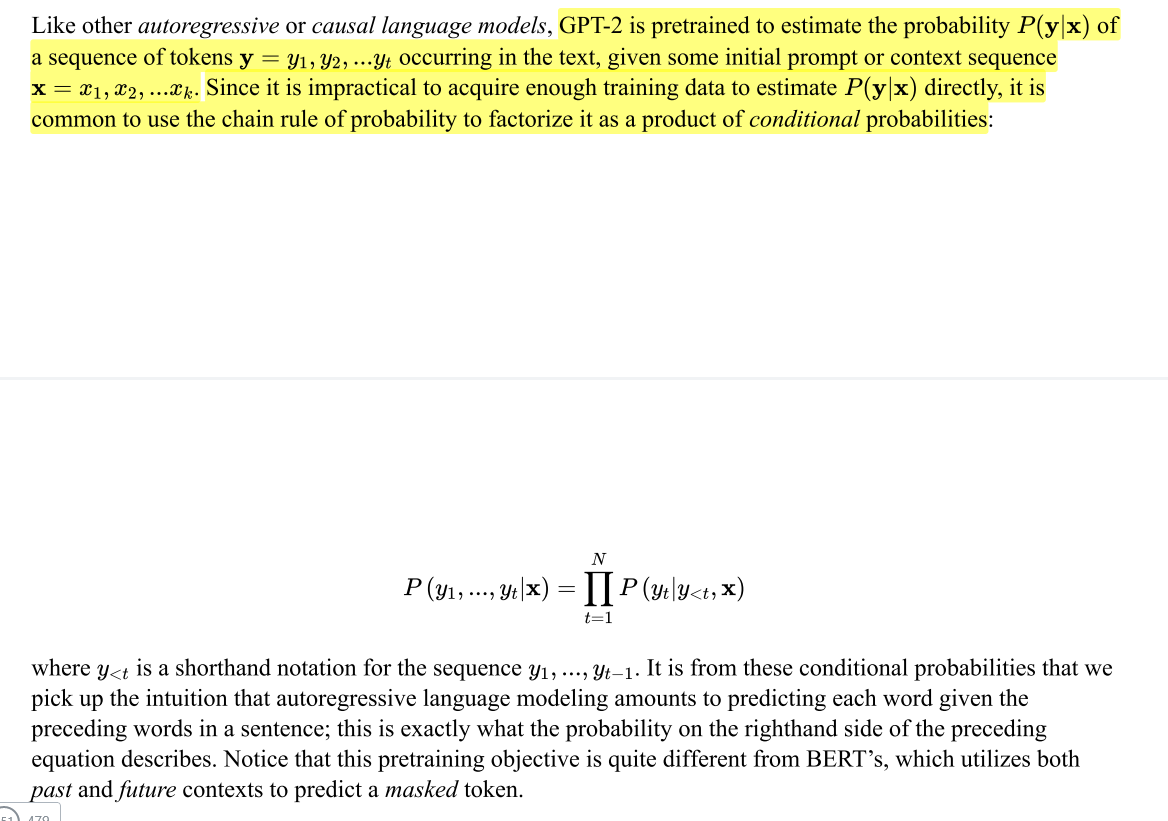

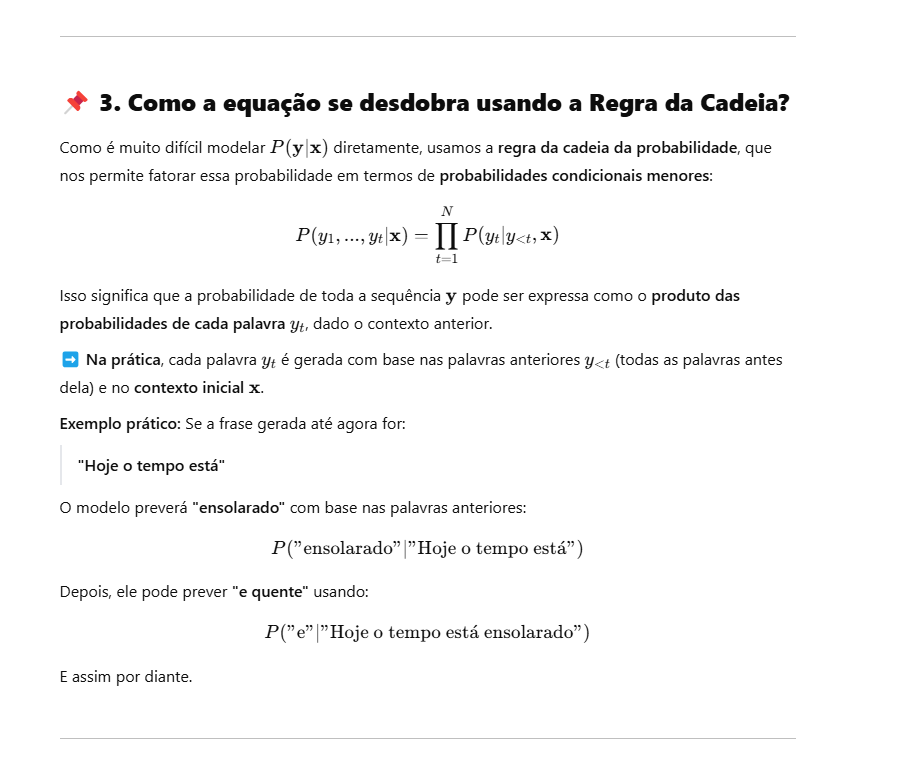

## Greedy Search Decoding

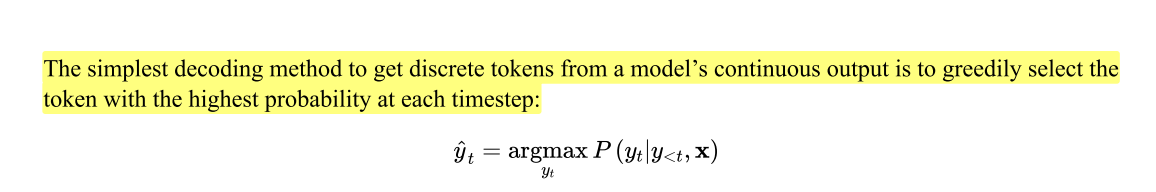

In [ ]:
# hide_output
# vamos carregar o GPT2 para ver como a greedy search funciona nesse caso
#A Language Modeling Head é a última camada do modelo GPT-2 responsável por gerar probabilidades sobre os próximos tokens da sequência
#AutoModelForCausalLM, que carrega automaticamente a cabeça de modelagem de linguagem

#AutoModelForCausalLM é a classe correta para carregar modelos autoregressivos, como o GPT-2, porque inclui automaticamente a cabeça de modelagem de linguagem.

#⚠️ Se usássemos apenas AutoModel, o modelo não teria essa camada final e não poderia prever palavras!

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

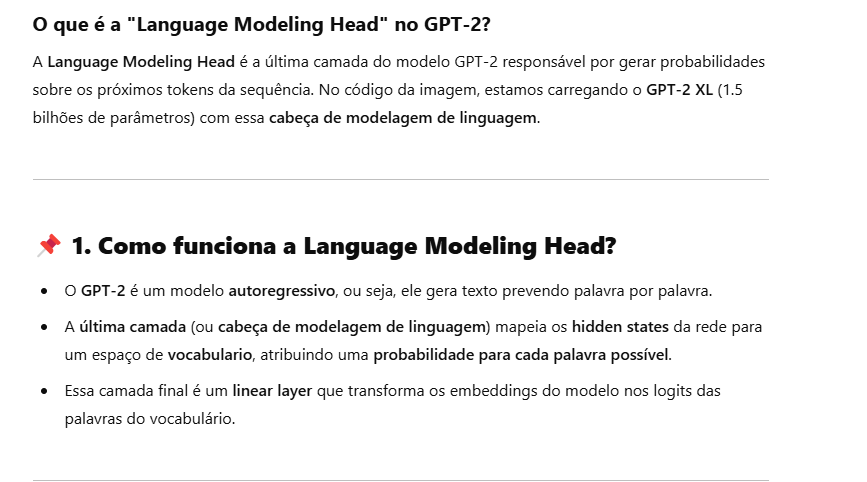

##Greedy Search -
vamos buscar a probabilidade mais alta e apenas ela a cada iteração. Greedy search é pouco utilizada na geração de texto,  mas pode ser util para produzir sequencias bem curtas

In [ ]:
# hide_output

#VAMOS TREINAR A GERAÇÃO DE TEXTOS
# O TRANFORMERS TEM A FUNÇÃO GENERATE(), MAS VAMOS IMPLEMENTAR NA MAO PARA ENTENDER COMO FUNCIONA
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device) # tokenizamos a frase de entrada
iterations = []
n_steps = 8 # qtdede intereações e palavras geradas
choices_per_step = 5 # quantidade de "mais provaveis" que vamos analisar

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0]) #converte IDs de tokens de volta para texto legível. Vamos entender em detalhes:
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]#output.logits[0, -1, :] → Pegamos apenas o último token gerado, pois queremos prever a próxima palavra.

        next_token_probs = torch.softmax(next_token_logits, dim=-1) #dim=-1 significa que estamos aplicando a Softmax ao longo da dimensão correspondente ao vocabulário.
        #a matriz de logits gerada pelo GPT2 é (logits.shape) → (batch_size, sequence_length, vocab_size).dim=-1 → Aplica Softmax ao longo da última dimensão, que é o tamanho do vocabulário.
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        #torch.argsort() ordena os índices dos tokens com base em suas probabilidades.
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):# Pegamos as 5 palavras mais prováveis
            token_id = sorted_ids[choice_idx]# Pegamos o índice da palavra
            token_prob = next_token_probs[token_id].cpu().numpy() #converte um tensor PyTorch em um valor numérico manipulável no NumPy.
            #.cpu() move os dados para a CPU para que possamos manipulá-los fora do PyTorch.  para cálculos numéricos externos (como visualização, armazenar em DataFrames, etc.), é mais conveniente trabalhar com arrays NumPy.
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            ) #O tokenizer.decode(token_id) converte esse número de volta para sua palavra original.
            #100 * token_prob → Converte a probabilidade para porcentagem

            iteration[f"Choice {choice_idx+1}"] = token_choice # aramazena no dicionario fazendo a contgagem começar com 1 e nao zero
           # função de formatar e armazenar as palavras mais prováveis que o modelo pode gerar na próxima etapa, juntamente com suas probabilidades.
        # Append predicted next token to input
        ## 5️⃣ Adicionamos o token mais provável à sequência gerada e repetimos o processo
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1) #Concatena o token previsto à sequência já gerada.
        iterations.append(iteration)
        #sorted_ids[None, 0, None]:
#sorted_ids[0] → Pegamos o ID do token mais provável.
#None serve para manter a dimensão do tensor compatível com input_ids.

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [ ]:
# agora vamos usar o generate

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device) # tokeniza a entrada e move o tensor para o dispositivo
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
#model.generate(): Chama o modelo para gerar tokens novos com base na entrada.
#do_sample=False: Significa que estamos usando Greedy Search (sempre escolhe o token mais provável).
#temperature=X: Controla a aleatoriedade na geração (valores altos tornam o texto mais criativo).
#top_k=50: Mantém apenas os 50 tokens mais prováveis em cada passo.
print(tokenizer.decode(output[0]))

Transformers are the most popular toy line in the world,


In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


## Beam Search Decoding
beam search keeps track of the top-b most probable next tokens, where b is referred to as the number of beams or partial hypotheses. The next set of beams are chosen by considering all possible next-token extensions of the existing set and selecting the b most likely extensions. The process is repeated until we reach the maximum length or an EOS token, and the most likely sequence is selected by ranking the b beams according to their log probabilities. An example of beam search is shown in Figure 5-4.



<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/>

In [ ]:
0.5 ** 1024
# fazemos log das probabildiades porque ficar multiplicando probabilidades ao longo de todo a frase daria um numero muito pequeno para ser processado e comparado


5.562684646268003e-309

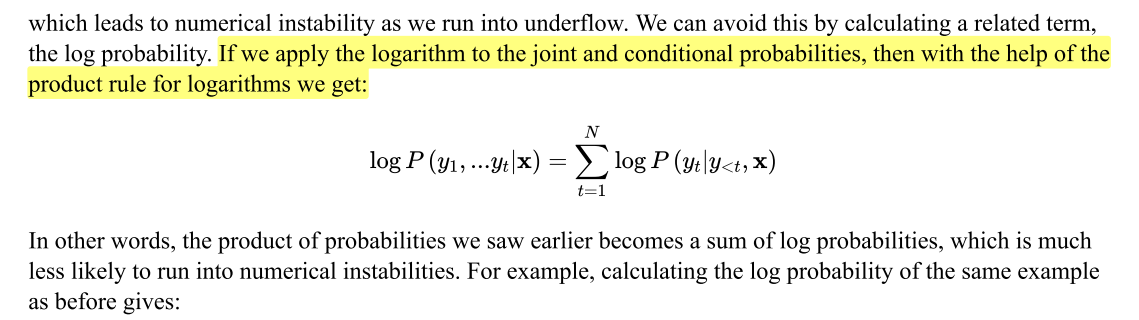

In [ ]:
import numpy as np

sum([np.log(0.5)] * 1024)
# veja a diferença de somar log de 0.5 1024 vezes. O valor fica muito mais expressivo e comparável
# o produto das probabilidades se torna a soma dos logs de probabilidade

-709.7827128933695

Since Transformers models return the unnormalized logits for the next token given the input tokens, we first need to normalize the logits to create a probability distribution over the whole vocabulary for each token in the sequence. We then need to select only the token probabilities that were present in the sequence. The following function implements these steps:

In [ ]:
import torch.nn.functional as F # importamos funções de ativação e loss

def log_probs_from_logits(logits, labels):
  # vamos criar a função pra transformar logits em probabildiades dinamicas (entram logits e as lavels que representam os tokens corretos)
  # vejamos que : logits tem dimensao (batch size, seq len, vocab_size), pois ele tem o logit calculado para cada palavra do vocabulario em cada posiçao dos tokens
  #já labels sao as labels corretas dos tokens que deveriam ser previstos e ele tem dimensao  (batch_size,seq_len)
    logp = F.log_softmax(logits, dim=-1)
     # dim=-1 significa que estamos normalizando ao longo da dimensão do vocabulário (ou seja, os logits de cada token serão convertidos para uma distribuição de probabilidade).

    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
     #Pegamos apenas os log-probs dos tokens que realmente apareceram na sequência.
   #A função torch.gather() permite selecionar elementos específicos de um tensor ao longo de uma dimensão.
  #torch.gather(logp, 2, labels.unsqueeze(2)):

#unsqueeze(2): Adiciona uma dimensão extra. Vejamos, o gather exige que busquemos logp em labels, mas eles obrigatoriamente devem ter as mesmas idmensoes
# antes do unsqueeze logp tem batchsize,seqlen,vocabsize e labels tem batch size seq len. Logo precisamos adicionar mais uma dimensao ao final
# agora sim buscamos a label no nosso vocabulario de probabilidades e geramos algo com batch size, seq len , 1
#squeeze(-1): Remove a dimensão extra para manter a forma correta do tensor. Essa dimensao criada não é mais necessaria porque nao agrega valor, nã é nela que temos a probabilidade coletada

    return logp_label

    # ISSO NOS DÁ A PROPABILIDADE PARA CADA UM DOS TOKENS, PARA TER A PROBABILIDADE DA SEQUENCIA NÓS FAZEMOS A SOMA DOS LOGS DAS PROBABILIDADES

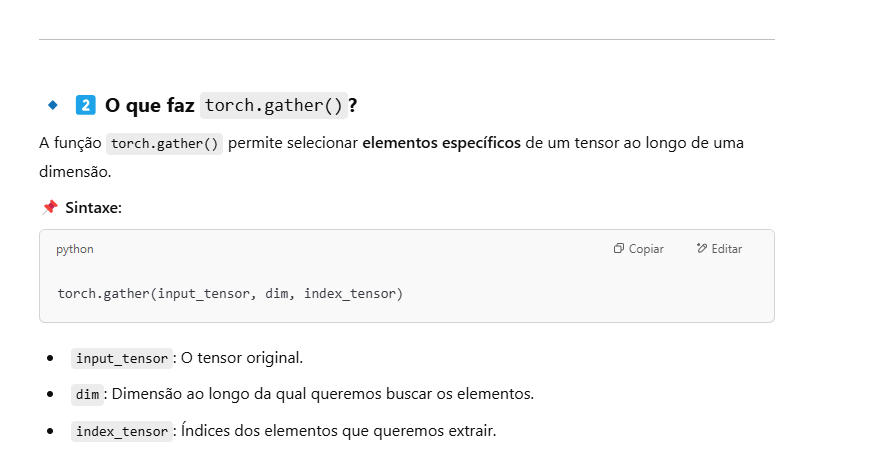

In [ ]:

    # PARA TER A PROBABILIDADE DA SEQUENCIA NÓS FAZEMOS A SOMA DOS LOGS DAS PROBABILIDADES
    #O parâmetro input_len (opcional), que indica até onde devemos ignorar os tokens iniciais (útil para evitar considerar o prompt).
    #Se aplicarmos essa função a diferentes sequências geradas pelo modelo (exemplo: uma sequência gerada com greedy search vs. outra com beam search), podemos comparar seus valores de log-probabilidade.
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels) #: labels é a entrada aqui, ou seja, a sequência já gerada.
        # a funçao desse modelo é gerar os logits para perver cada proxima palavra da nossa sequencia de entrada
        # ou seja, entramos com nossas labels e ele vai gerar as previsoes das proximas palavras para calcularmos as probabilidades

        # como esstamos trabalhando com uma LLM como o GPT, durante seu treinamento o modelo é treinado para prever o proximo token da sequencia
        #entao a sequencia ja e passada para ele e assim tentamos ver como ele fez essa previsao
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        #output.logits tem shape (batch_size, seq_len, vocab_size).
        #logits[:, :-1, :]: Remove o último porque não existe mais token seguinte para prever.
        # o gpt nao insere cls, entao ao retirar o ultimo token da sequencia e o primeiro label nos continuamos com comprimentos igausi
        #Removemos o último token na dimensão da sequência ([:, :-1, :]). Como estamos prevendo o próximo token na sequência, removemos o último token da previsão para alinhar as entradas.
       # labels[:, 1:] remove o primeiro token das labels. Queremos prever o próximo token, então deslocamos os labels uma posição à fren

       # IMPORTANTE : A LOGICA É A SEGUINTE, DEVEMOS VERIFICAR A PROBABILIDADE DO PROXIMO TOKEN DADO OS TOKENS ANTERIORES, POR ISSO DEVEMOS EXCLUIR O ULTIMO DA SEQ E RETIRAR O PRIMEIRO LABEL
       #ASSIM AO JOGARMOS  log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:]) ESTAMOS CALCULANDO A PROBABILDIADE DE PREER O PROX TOKEN DADA UMA SEQUENCIA


        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()
    # Saída: A função retorna a soma dos log-probabilities da sequência gerada pelo modelo.

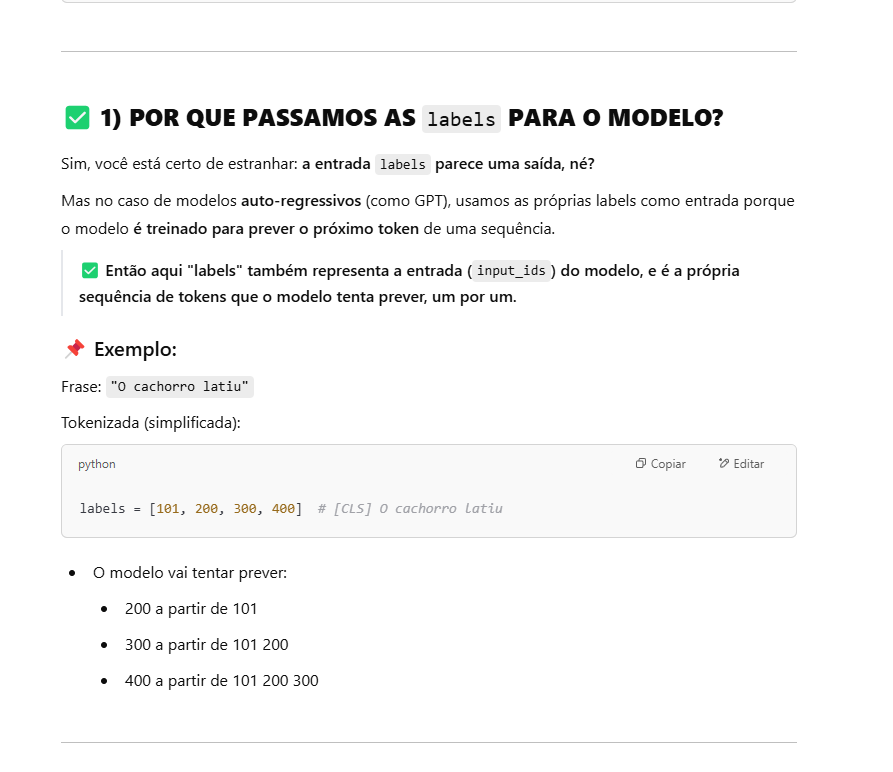

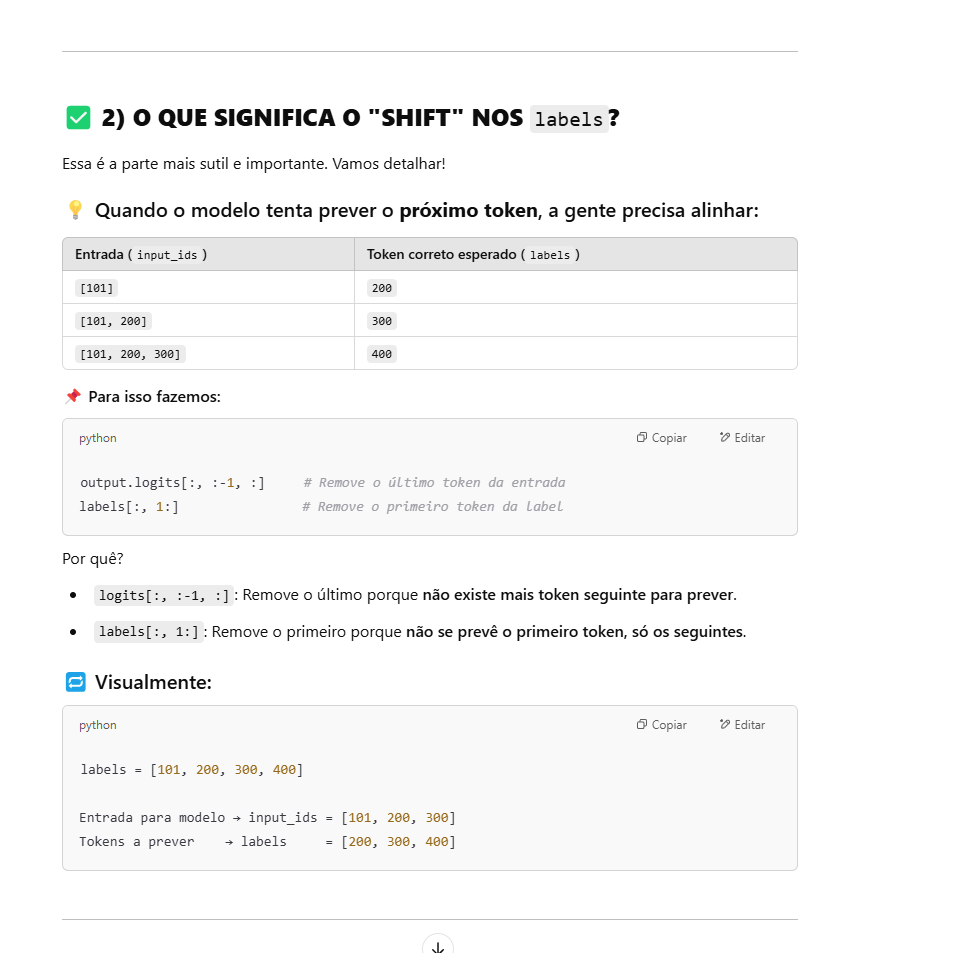

### Vamos comparar o greedy seach com o beam search

In [ ]:
#Aqui, chamamos a função sequence_logprob() para calcular a probabilidade logarítmica total da sequência gerada pelo modelo usando greedy search.
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
#Ignoramos os logits dos tokens de entrada → porque não foram gerados pelo modelo, eles foram passados como entrada.
print(tokenizer.decode(output_greedy[0]))#tokenizer.decode(output_greedy[0]) → Converte os IDs dos tokens de volta para texto legível.
print(f"\nlog-prob: {logp:.2f}")
# Quanto mais negativo for o log-prob, menor a probabilidade da sequência ser correta!

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


In [ ]:
#Agora, o código faz a mesma coisa, mas usando beam search para melhorar a geração.


output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
#num_beams=5 → Define o número de caminhos candidatos explorados na beam search.
#➝ Em vez de apenas pegar o token mais provável a cada passo (greedy search), o modelo mantém 5 sequências candidatas e escolhe a melhor ao final.
#do_sample=False → Garante que a geração não seja aleatória. O modelo sempre escolherá o melhor caminho determinado pela beam search.

logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains. Even more surprising to the researchers was the fact
that the unicorns spoke perfect English

log-prob: -55.23


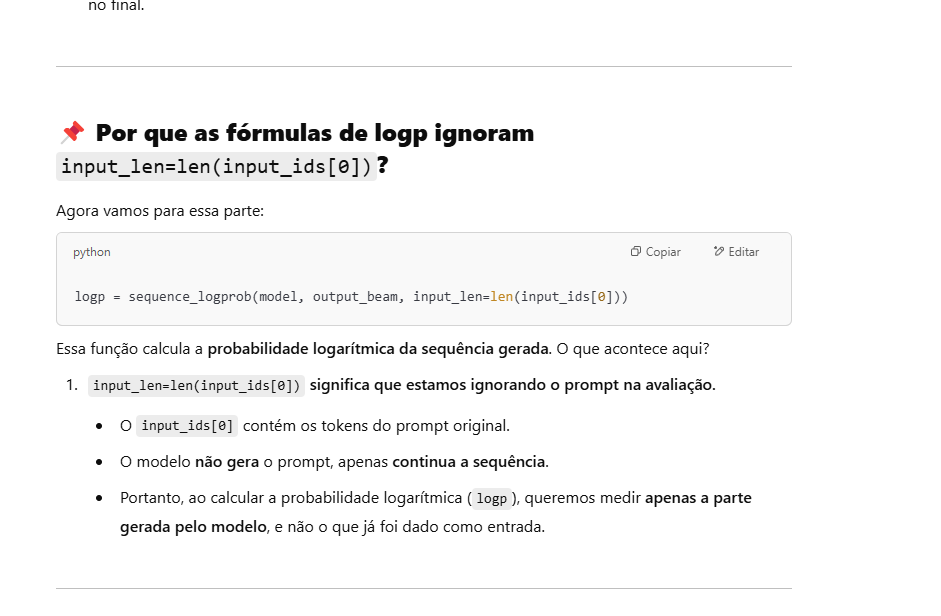

In [ ]:

# podemos ver que ate mesmo o beam search sofre gerando textos repetitivos, para mitigar isso podemos usar
#no_repeat_ngram_size=2
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
#no_repeat_ngram_size=2 significa que nenhum bigrama (sequência de 2 palavras) pode se repetir na geração.
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of scientists from the University of
California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the
area when they came across the herd. They were surprised to find that they were
able to converse with the animals in English, even though they had never seen a
unicorn in person before. The researchers were

log-prob: -93.12


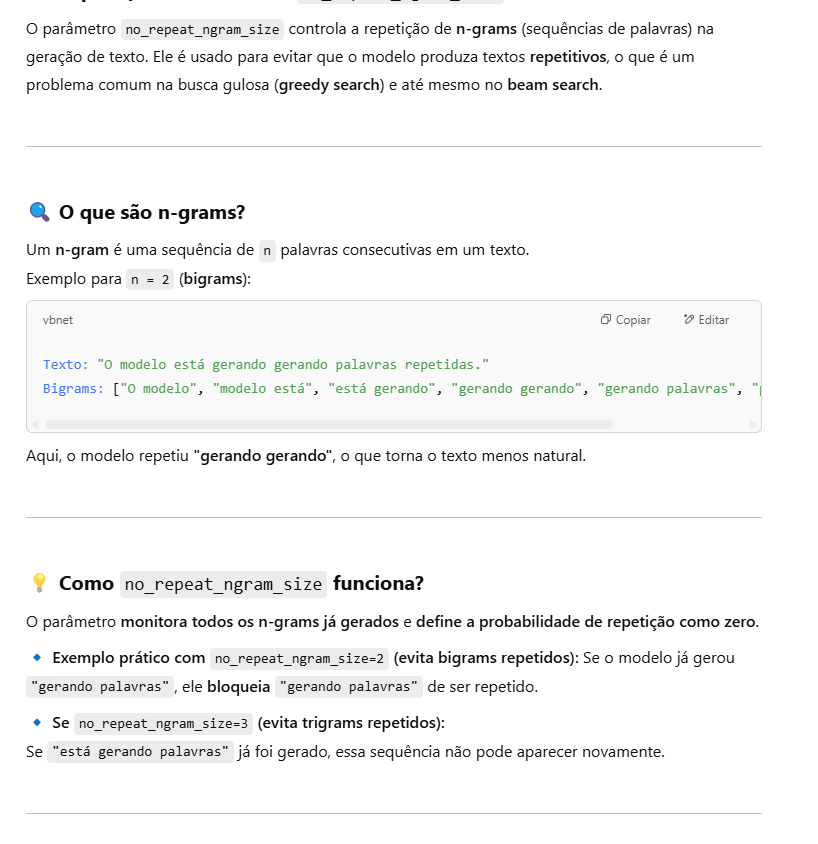

## Sampling Methods

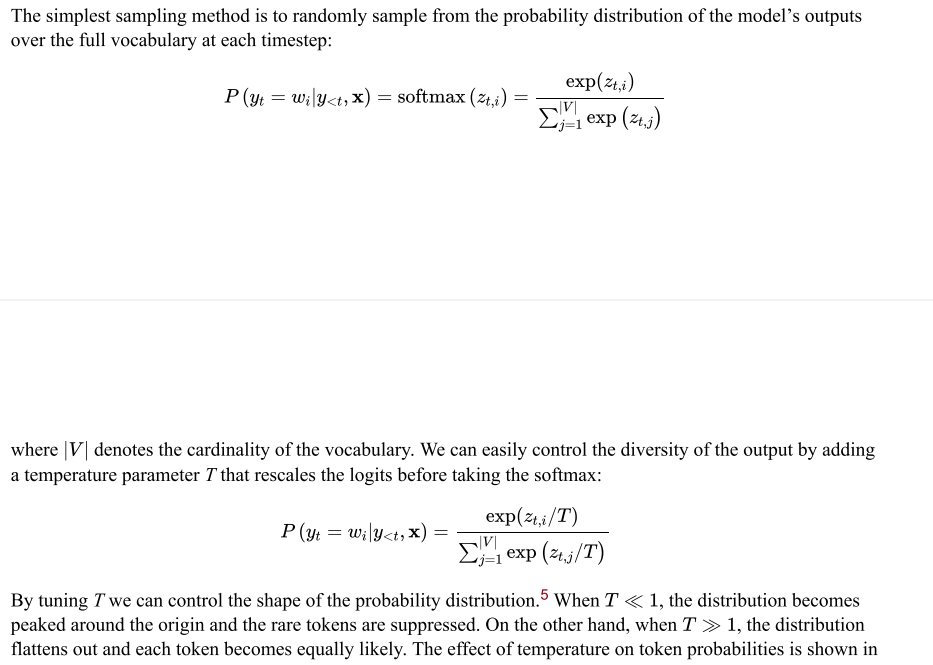

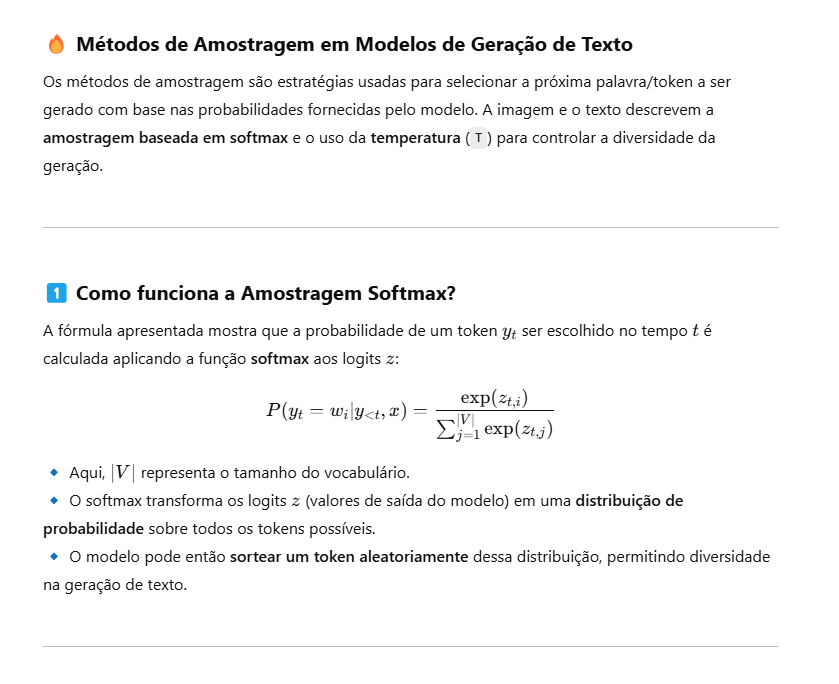

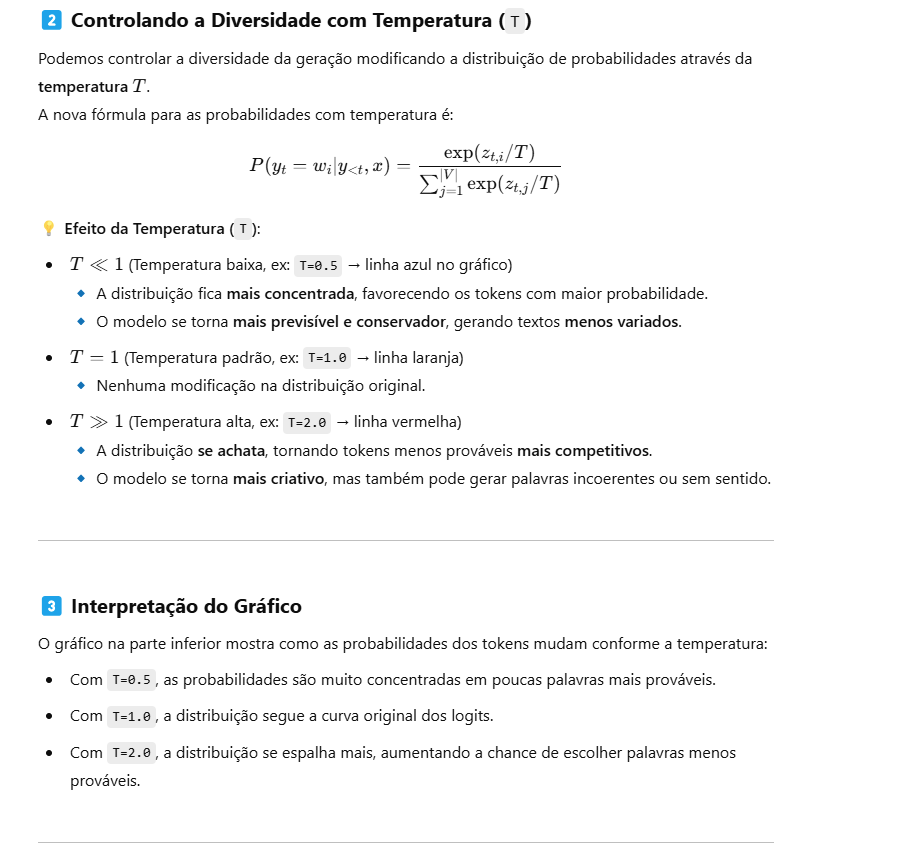

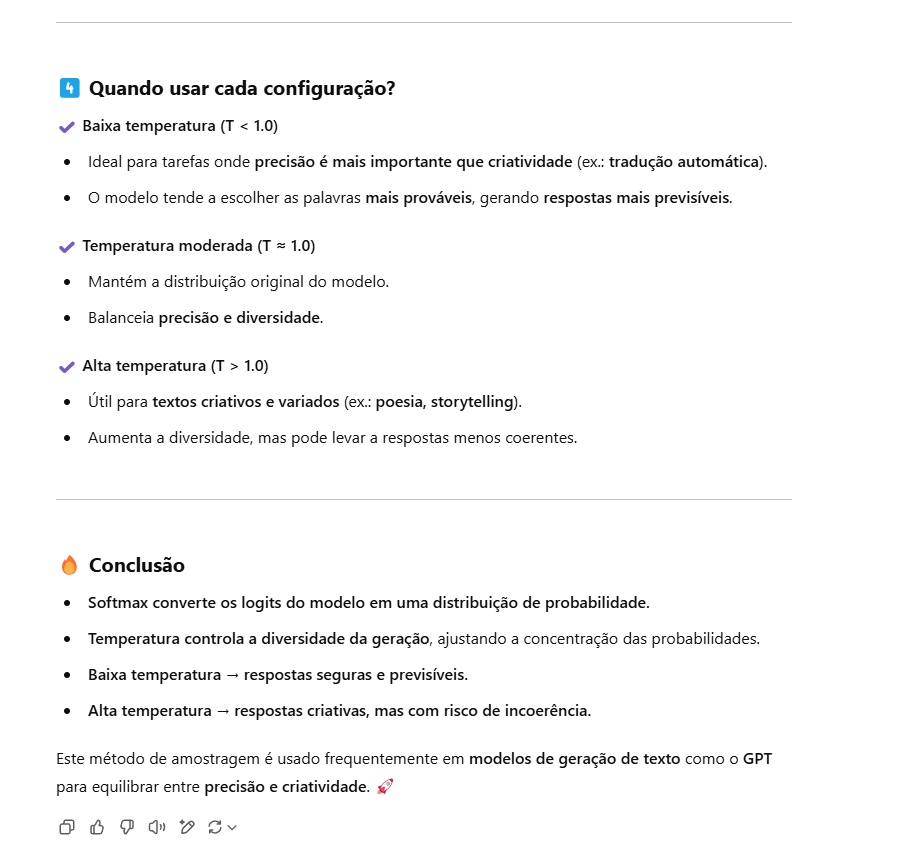

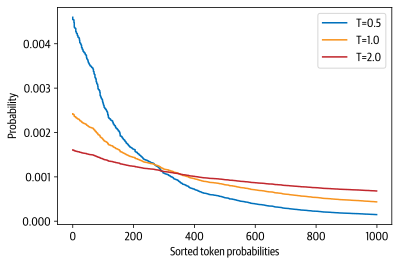

In [ ]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T) # aplica a softmax com temperatura
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
#np.sort(arr) → Ordena os valores do menor para o maior.
# [::-1] → Faz um "espelhamento" do array, invertendo a ordem.

x = np.arange(1000)
# Gera 1.000 valores aleatórios de logits usando np.random.random(1000).
#🔹 Depois, aplica np.exp() para simular scores típicos de um modelo de linguagem.

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

# veja que ordenamos as probabilidades para ver como a tempeatura afeta a distribuiçao dentro de uma softmax

In [ ]:
# hide
torch.manual_seed(42);

To see how we can use temperature to influence the generated text, let’s sample with T = 2 by setting the temperature parameter in the generate() function (we’ll explain the meaning of the top_k parameter in the next section

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))
#Se usarmos do_sample=True → O modelo escolhe aleatoriamente um token, respeitando a distribuição ajustada.
#Se usarmos do_sample=False → O modelo sempre escolhe o token com maior probabilidade (busca gulosa, ou greedy search).
#Temperatura só ajusta as probabilidades, mas a escolha pode ser aleatória ou não.

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


While the station aren protagonist receive Pengala nostalgiates tidbitRegarding
Jenny loclonju AgreementCON irrational �rite Continent seaf A jer Turner
Dorbecue WILL Pumpkin mere Thatvernuildagain YoAniamond disse *
Runewitingkusstemprop});b zo coachinginventorymodules deflation press
Vaticanpres Wrestling chargesThingsctureddong Ty physician PET KimBi66 graz Oz
at aff da temporou MD6 radi iter


We can clearly see that a high temperature has produced mostly gibberish; by accentuating the rare tokens, we’ve caused the model to create strange grammar and quite a few made-up words! Let’s see what happens if we cool down the temperature

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists were searching for the source of the mysterious sound, which was
making the animals laugh and cry.


The unicorns were living in a remote valley in the Andes mountains

'When we first heard the noise of the animals, we thought it was a lion or a
tiger,' said Luis Guzman, a researcher from the University of Buenos Aires,
Argentina.


'But when


This is significantly more coherent, and even includes a quote from yet another university being credited with the discovery! The main lesson we can draw from temperature is that it allows us to control the quality of the samples, but there’s always a trade-off between coherence (low temperature) and diversity (high temperature) that one has to tune to the use case at hand.
Another way to adjust the trade-off between coherence and diversity is to truncate the distribution of the vocabulary. This allows us to adjust the diversity freely with the temperature, but in a more limited range that excludes words that would be too strange in the context (i.e., low-probability words). There are two main ways to do this: top-k and nucleus (or top-p) sampling. Let’s take a look.

## Top-k and Nucleus Sampling

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [ ]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

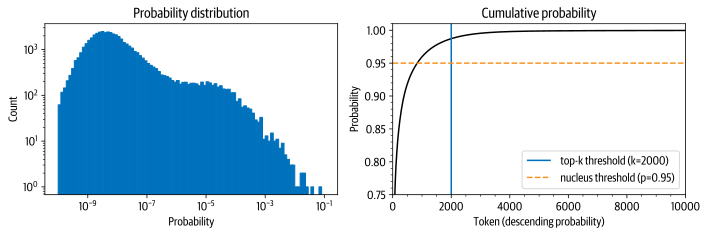

In [ ]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the
border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire
Naturelle)

The researchers came across about 50 of the animals in the valley. They had
lived in such a remote and isolated area at that location for nearly a thousand
years that


In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came to the conclusion that
the herd are descendants of a prehistoric herd that lived in Argentina about
50,000 years ago.


According to the scientific analysis, the first humans who migrated to South
America migrated into the Andes Mountains from South Africa and Australia, after
the last ice age had ended.


Since their migration, the animals have been adapting to


## Which Decoding Method Is Best?

## Conclusion